In [21]:
import sys
sys.path.append("..")
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import time
from PIL import Image
import os
import shutil
import subprocess
from tqdm import tqdm

from utils.shapefiles import sampleShapefileLocations
from utils.divtree_gen import *
from utils.seqdata_gen import *
from utils.seq2demodst import *
from utils.coords import *
from utils.noise import *
from utils.metrics import *
from analysis.peaksdata import *

%matplotlib inline
mpl.rcParams['image.cmap'] = 'terrain'

In [22]:
np.random.seed(42)

In [23]:
promEpsilon   = 30   # m,  minimum prominence threshold in the analysis
diskRadius    = 30   # km, used for the analysis to normalize histograms 
globalMaxElev = 9000 # m,  any value larger than any other peak elevation, used internally as initialization and undefineds

terrainUnitKm  = 90  # km, size of terrain
km2pixels = 1000/30  # 30 m/pixel

# process each region (note: it takes a long time!)
regionShapesDir = '../data/regionShapes'
regionPeaksDir = 'data/regionPeaks'
regionSeqsDir = 'data/regionSeqs'
regionTreeSeqsDir = 'data/regionTreeSeqs'


regionShapes = ['andes_peru.shp']

In [24]:
#regionName, filterCoords = 'pyrenees', [42.5893, 0.9377] # pyrenees: aiguestortes
#regionName, filterCoords = 'alps', [45.8325,  7.0]  # mont blanc
#regionName, filterCoords = 'alps', [44.8742,  6.5]  # ecrins
#regionName, filterCoords = 'alps', [46.4702, 11.9492] # dolomites
#regionName, filterCoords = 'alps', [46.0159, 7.74318] # valais
#regionName, filterCoords = 'sahara', [30.38, 8.69] # sahara dunes
#regionName, filterCoords = 'andes_chile', [-21.4483, -68.0708] # chile
#regionName, filterCoords = 'karakoram', [35.8283, 76.3608] # karakoram
#regionName, filterCoords = 'colorado', [39.0782,-106.6986] # colorado
#regionName, filterCoords = 'yangshuo', [24.9917, 110.4617] # yangshuo
#regionName, filterCoords = 'himalaya', [28.7150, 84.2000] # himalaya: annapurna
#regionName, filterCoords = 'himalaya', [27.8575, 86.8267] # himalaya: everest
#regionName, filterCoords = 'norway', [62.1167, 6.8075] # norway
#regionName, filterCoords = 'alaska', [62.9500, -151.0908] # alaska
#regionName, filterCoords = 'patagonia', [-50.8925, -73.1533] # patagonia
#regionName, filterCoords = 'andes_aconcagua', [-32.6533, -70.0108] # aconcagua
regionName, filterCoords = 'andes_peru', [-9.0874, -77.5737] # huascaran
#regionName, filterCoords = 'rockies', [50.8003, -116.29517] # canadian rockies
#regionName, filterCoords = 'appalachians', [35.3855, -83.2380] # appalachians
#regionName, filterCoords = 'highlands', [56.9667, -3.5917] # highlands

peaksFile = '../data/regionPeaks/%s.csv' % regionName

filterRadius = 90 # km
filterHWidth = [km2deg(filterRadius), km2deg(filterRadius, filterCoords[0])]
print("filter scope: ",filterCoords[0] - filterHWidth[0], filterCoords[0] + filterHWidth[0],
      filterCoords[1] - filterHWidth[1], filterCoords[1] + filterHWidth[1])

# read peaks file and filter region of interest
df = pd.read_csv(peaksFile)

filat = np.logical_and(df['latitude']  > filterCoords[0] - filterHWidth[0], 
                       df['latitude'] < filterCoords[0] + filterHWidth[0])
filon = np.logical_and(df['longitude'] > filterCoords[1] - filterHWidth[1], 
                       df['longitude'] < filterCoords[1] + filterHWidth[1])
df = df[np.logical_and(filat, filon)]

print('Peaks:', df.shape[0])

filter scope:  -9.89724774862326 -8.277552251376742 -78.39384170503196 -76.75355829496804
Peaks: 4314


### Visualize the peaks

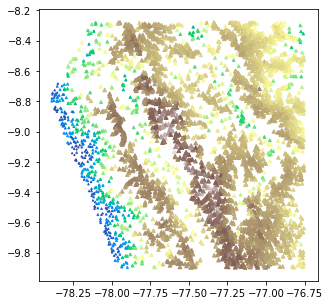

In [25]:
# compute distributions
df = addExtraColumns(df)
fig = plt.figure(figsize=(5,5))
_ = plt.scatter(df['longitude'], df['latitude'], marker='^', 
                s=20*df['elev'].values/df['elev'].values.max(), c=df['elev'].values/df['elev'].values.max())

In [26]:
print(len(df))

4314


### Generrate Sequence

In [15]:
import pickle
bfsseqdata_file_name = 'HMM_Seq_bfs.data'
dfsseqdata_file_name = 'HMM_Seq_dfs.data'
diskRadius = 20
if os.path.exists(bfsseqdata_file_name) and os.path.exists(dfsseqdata_file_name):
    with open(bfsseqdata_file_name, 'rb') as seqdata_file:
        bfsTrees = pickle.load(seqdata_file)
    with open(dfsseqdata_file_name, 'rb') as seqdata_file:
        dfsTrees = pickle.load(seqdata_file)
else:
    print(os.path.join(regionShapesDir, 'andes_peru.shp'))
    sampleLocations = sampleShapefileLocations(os.path.join(regionShapesDir, 'andes_peru.shp'), diskRadius)
    print(regionName, ": ", len(sampleLocations), "samples")
    bfsTrees = []
    dfsTrees = []
    # compute sequences
    for di,diskCenter in tqdm(enumerate(sampleLocations)):
        peaks = filterPeaksHaversineDist(df, diskCenter, diskRadius)
        if peaks.shape[0] < 10:
            continue
        rootNode = genDivideTree(peaks)
        seqOfTree_bfs = genFullSeqHMM(rootNode, isDFS=False)
        seqOfTree_dfs = genFullSeqHMM(rootNode, isDFS=True)
        bfsTrees.append(seqOfTree_bfs)
        dfsTrees.append(seqOfTree_dfs)

    with open(bfsseqdata_file_name, 'wb') as seqdata_file:
        pickle.dump(bfsTrees, seqdata_file)
    with open(dfsseqdata_file_name, 'wb') as seqdata_file:
        pickle.dump(dfsTrees, seqdata_file)

bfsseqdata_file_name = 'HMM_Seq_bfs_big.data'
dfsseqdata_file_name = 'HMM_Seq_dfs_big.data'

if os.path.exists(bfsseqdata_file_name) and os.path.exists(dfsseqdata_file_name):
    with open(bfsseqdata_file_name, 'rb') as seqdata_file:
        bfsTreeBig = pickle.load(seqdata_file)
    with open(dfsseqdata_file_name, 'rb') as seqdata_file:
        dfsTreeBig = pickle.load(seqdata_file)
else:
    rootNode = genDivideTree(df)
    bfsTreeBig = genFullSeqHMM(rootNode, isDFS=False)
    dfsTreeBig = genFullSeqHMM(rootNode, isDFS=True)

    with open(bfsseqdata_file_name, 'wb') as seqdata_file:
        pickle.dump(bfsTreeBig, seqdata_file)
    with open(dfsseqdata_file_name, 'wb') as seqdata_file:
        pickle.dump(dfsTreeBig, seqdata_file)

In [16]:
def drawResult(edges):
    X = []
    Y = []
    for v, w in edges:
        X.append([v[0], w[0]])
        Y.append([v[1], w[1]])
    for i in range(len(X)):
        plt.plot(X[i], Y[i], color='r')

def drawResultOrder(peakList):
    X = []
    Y = []
    for i in range(len(peakList)-1):
        X.append([peakList[i][0], peakList[i+1][0]])
        Y.append([peakList[i][1], peakList[i+1][1]])
    for i in range(len(X)):
        plt.plot(X[i], Y[i], color='r')

### define model (HMM)

In [17]:
from hmmlearn import hmm

In [18]:
# little dataset
lengths = []
bfsTrees_flat = []
dfsTrees_flat = []
for i, seq in enumerate(bfsTrees):
    lengths.append(len(seq))
    bfsTrees_flat += bfsTrees[i]
    dfsTrees_flat += dfsTrees[i]


In [19]:
# gmm = hmm.GMMHMM(4, 1)
gmm = hmm.GaussianHMM(4)
gmm = gmm.fit(bfsTrees_flat, lengths)
gmm.score(bfsTrees_flat, lengths)

# ext_set = []
# ext_length = []
# for i in range(10):
#     ext_set += dfsTreeBig
#     ext_length.append(len(dfsTreeBig))
# gmm = gmm.fit(ext_set, ext_length)
# gmm.score(dfsTreeBig)

-28750.36354870592

In [20]:
print(gmm.get_stationary_distribution())

[0.59164176 0.20842195 0.05103922 0.14889707]


## Test prediction

### Prediction

In [339]:
predictLen = 200
pointlist = [[df.mean()['longitude'], df.mean()['latitude'], df.max()['elevation in feet'],df.mean()['prominence in feet']]]
deltaslist = [[0.0, 0.0, 0.0, 0.0]]
plt.rcParams['figure.figsize'] = (6.0, 4.0)
predict = gmm.sample(predictLen)[0]
for i in range(predictLen):
    deltas = predict[i]
    deltaslist.append(deltas)
    point = [0,0,0,0]
    for i in range(4):
        point[i] = pointlist[-1][i] + deltas[i]
    pointlist.append(point)



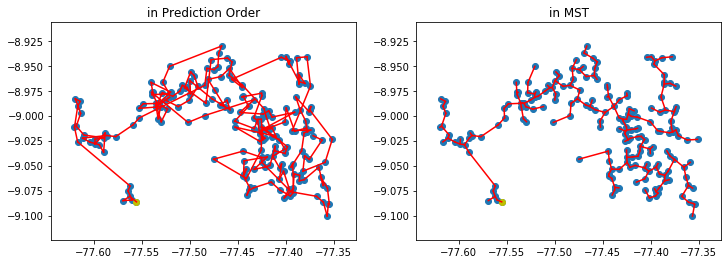

In [340]:
apointlist = np.array(pointlist)
peaks = [list(p) for p in apointlist[:, :2]]
edges = getTreeHMC(peaks)
plt.rcParams['figure.figsize'] = (12.0, 4.0)
# in order
plt.subplot(121)
plt.scatter(apointlist[:,0], apointlist[:,1])
drawResultOrder(apointlist)
plt.scatter(apointlist[0,0], apointlist[0,1], c='y')
plt.title('in Prediction Order')
# in MST
plt.subplot(122)
plt.scatter(apointlist[:,0], apointlist[:,1])
drawResult(edges)
plt.scatter(apointlist[0,0], apointlist[0,1], c='y')
plt.title('in MST')
# plt.savefig('../note.assets/hmm_small_exm.png')
plt.show()


In [341]:
plt.savefig('../note.assets/hmm_small_exm.png')

<Figure size 864x288 with 0 Axes>

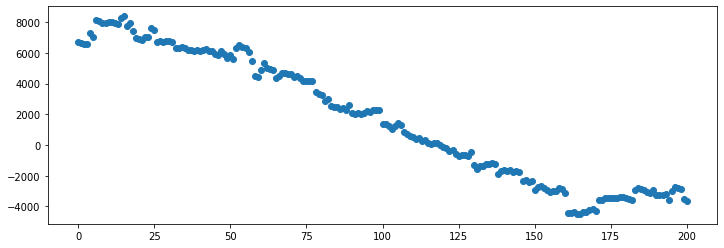

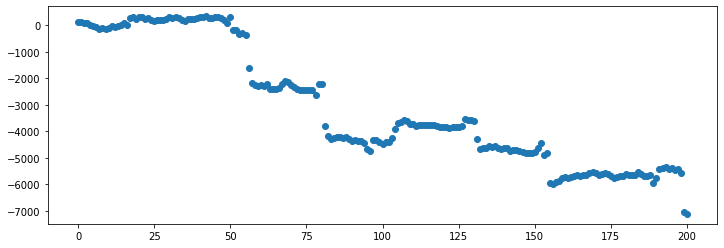

In [342]:
xx = [i for i in range(predictLen+1)]
elepre = [feet2m(apointlist[i][2]) for i in range(predictLen+1)]
propre = [feet2m(apointlist[i][3]) for i in range(predictLen+1)]
plt.scatter(xx, elepre)
# plt.savefig('../note.assets/hmm_64_ele_exm.png')
plt.show()
plt.scatter(xx, propre)
# plt.savefig('../note.assets/hmm_64_pro_exm.png')


## Evaluation

In [343]:
# compute distributions
df = addExtraColumns(df)
distributions = computeDistributions(df, diskRadius)

In [344]:
barColor  = (216/255, 226/255, 238/255, 1.0)
edgeColor = (137/255, 151/255, 168/255, 1.0)

def printHistogramsDistances(hbins, hReal, hSynth):
    hdiff = np.abs(hReal - hSynth)
    print('Max', np.max(hdiff), 'Sum', np.sum(hdiff), 'Avg', np.mean(hdiff))
    print('EMD', np.diff(hbins)[0]*np.abs(np.cumsum(hReal) - np.cumsum(hSynth)).sum())
    
def histogramsComparison(distribution, synthesisValues):
    hbins  = distribution['bins']
    hmids  = distribution['x']
    hReal  = distribution['hist']
    hSynth = histogramFromBins(synthesisValues, hbins, frequencies=False)
    hNorm  = np.round(synthesisValues.size * hReal/hReal.sum())

    fig = plt.figure(figsize=(16, 5))
    ax = fig.add_subplot(131)
    _ = ax.bar (hmids, hSynth, width=np.diff(hbins), color=barColor, edgecolor=edgeColor)
    _ = ax.plot(hmids, hNorm, color='r')

    ax = fig.add_subplot(132)
    _ = ax.bar (hmids, hNorm, width=np.diff(hbins), color='g')
    _ = ax.plot(hmids, hNorm, color='r')
    
    printHistogramsDistances(hbins, hReal/hReal.sum(), hSynth/hSynth.sum())
    print('Per bin differences (synthesis - target)')
    print(hSynth - hNorm)

Max 0.10501419110690634 Sum 1.456196783349101 Avg 0.017335675992251203
EMD 1653.4602649006615
Per bin differences (synthesis - target)
[  2.   3.   1.   1.   3.   1.   1.   0.   1.   0.   1.   0.   2.   3.
   1.   0.   0.   0.   0.   0.   5.   1.   3.   2.   1.   1.  -1.   0.
   1.  -2.   0.  -2.  -1.  -2.   0.  -2.  -2.  -2.  -1.  -4.  -3.  -4.
 -17. -15.  -5. -15. -15. -21. -11.  -6.  -9.  -6.  -5.  -5.  -2.  -3.
  -2.  -2.   0.   0.   1.   5.   5.   2.   1.   3.   2.   6.   1.   2.
   3.   0.   1.   0.   2.   0.   1.   1.   1.   5.   3.   2.   0.   0.]


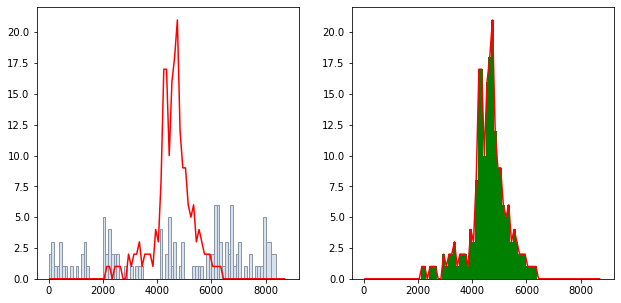

In [345]:
histogramsComparison(distributions['elevation'], np.array(elepre))

Max 0.33721762004753447 Sum 1.3845905346470682 Avg 0.03377050084505044
EMD 154.05773357639018
Per bin differences (synthesis - target)
[-76. -66. -22.  -7.   2.   7.   8.  -1.  -1.   0.  -1.   0.  -1.  -1.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]


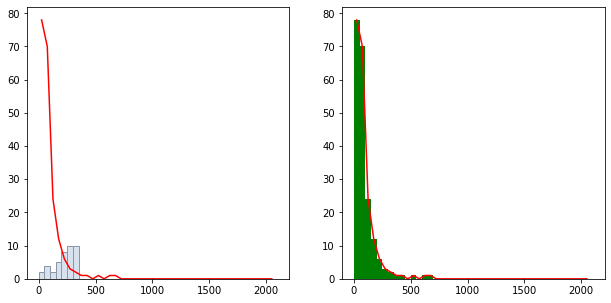

In [346]:
histogramsComparison(distributions['prominence'], np.array(propre))